Illustrate a trivial model which is passed a vector of known multiples of 13, 
and check whether inbound values match known values.

This principally shows the indexing mechanism at work, with 'cumsum' conv layer.

It is worth noting that a regular dense model is not easily able to perform this task with supervised learning. If a model is trained to do this, it requires learnable weights.

In [49]:
import tensorflow as tf
import tensorflow.keras as keras
from keras import layers
from keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
testRange = 256*13
XAll = np.arange(testRange)
YAll = np.mod(XAll , 13)==0
print(YAll[:26])


[ True False False False False False False False False False False False
 False  True False False False False False False False False False False
 False False]


In [51]:
XAll = XAll[:, np.newaxis, np.newaxis, np.newaxis]
np.shape(XAll)

(3328, 1, 1, 1)

In [52]:
np.random.seed(123)
r = np.random.permutation(testRange)
XAll = XAll[r,:,:,:]
YAll = YAll[r]
splitIdx = 4*testRange // 5
XTrain = XAll[:splitIdx]
XVal = XAll[splitIdx:]
YTrain = YAll[:splitIdx]
YVal = YAll[splitIdx:]

In [53]:
inputData = np.arange(0, 256*13, 13).reshape(16,16,1)
print(inputData[:5,:5])

np.shape(inputData)

[[[  0]
  [ 13]
  [ 26]
  [ 39]
  [ 52]]

 [[208]
  [221]
  [234]
  [247]
  [260]]

 [[416]
  [429]
  [442]
  [455]
  [468]]

 [[624]
  [637]
  [650]
  [663]
  [676]]

 [[832]
  [845]
  [858]
  [871]
  [884]]]


(16, 16, 1)

In [54]:
inputs_multiples = keras.Input(shape=(16,16,1))



In [55]:
from keras import backend as K
from keras.layers import Layer, Lambda
# simpler non-learnable layer, activation only
def radbas(n, epsil=1):
    n = tf.convert_to_tensor(n, dtype=tf.float32)
    epsil = tf.convert_to_tensor(epsil, dtype=tf.float32)
    result = keras.ops.exp(-(n*epsil)**2)
    return result
radbas(0)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [56]:
CNN_input = layers.Input(shape=(1, 1, 1),name="CNN_in")
# Decoder like layers. Upsample width and height from 1 to 2,4,8,16

CNN_layer256 = Lambda(keras.backend.tile, arguments={'n':(1, 16, 16, 1)})(CNN_input)

# Combine models
mergedOut = layers.Add()([inputs_multiples,CNN_layer256])
#x = RBFLayer(1, 10)(mergedOut)
x = Lambda(radbas)(mergedOut)
# Encoder like layers. Downsample width and height from 16 to 8,4,2,1
#x = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
#x = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
#x = layers.Conv2D(8, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
#x = layers.Conv2D(4, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
#x = layers.Conv2D(1, (1, 1), activation="sigmoid", padding="same")(x)
output = layers.Flatten(name="output")(x)

# CNN
CNN_model = keras.Model(inputs=[inputs_multiples, CNN_input], outputs=output)
CNN_model.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
loss=tf.keras.losses.BinaryCrossentropy(),
metrics=[tf.keras.metrics.BinaryAccuracy(),
         tf.keras.metrics.FalseNegatives(),
         tf.keras.metrics.FalsePositives()],
)
CNN_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ CNN_in (InputLayer) │ (None, 1, 1, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 16, 16, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 16, 16, 1) │          0 │ CNN_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 16, 16, 1) │          0 │ input_layer_4[0]… │
│                     │                   │            │ lambda_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 16, 16, 1) │          0 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 8, 8, 1)   │          0 │ lambda_5[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 4, 4, 1)   │          0 │ max_pooling2d_8[… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 2, 2, 1)   │          0 │ max_pooling2d_9[… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 1, 1, 1)   │          0 │ max_pooling2d_10… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Flatten)    │ (None, 1)         │          0 │ max_pooling2d_11… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [57]:

inputDataBcast = np.tile(inputData, [len(XTrain),1,1,1])
print(np.shape(inputData))
print(np.shape(inputDataBcast))

# note: no training in reality, since no learnable weights!
CNN_model.fit([inputDataBcast,-1*XTrain], YTrain)

(16, 16, 1)
(2662, 16, 16, 1)
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - binary_accuracy: 1.0000 - false_negatives_2: 0.0000e+00 - false_positives_2: 0.0000e+00 - loss: 0.0777


In [58]:
inputDataBcast = np.tile(inputData, [len(XVal),1,1,1])
p = CNN_model.predict([inputDataBcast,-1*XVal])
accu = np.mean(np.squeeze(np.round(p))==YVal)
print(accu)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1.0


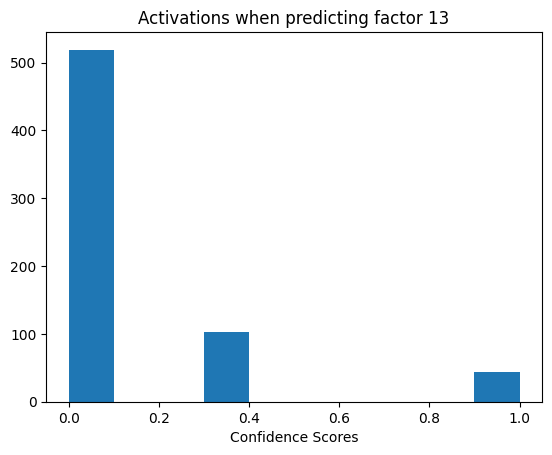

In [59]:
plt.hist(p)
plt.xlabel("Confidence Scores")
plt.title("Activations when predicting factor 13")
plt.show()

In [60]:
# print out any incorrect results
x = np.where(np.squeeze(np.round(p))!=YVal)
print(x)
print(YVal[np.where(np.squeeze(np.round(p))!=YVal)])
print(p[np.where(np.squeeze(np.round(p))!=YVal)])

(array([], dtype=int64),)
[]
[]


this now seems to work, no learnable layers needed.

View layers

In [61]:
for i,l in enumerate(CNN_model.layers):
    print(i,l)

0 <InputLayer name=CNN_in, built=True>
1 <InputLayer name=input_layer_4, built=True>
2 <Lambda name=lambda_4, built=True>
3 <Add name=add_2, built=True>
4 <Lambda name=lambda_5, built=True>
5 <MaxPooling2D name=max_pooling2d_8, built=True>
6 <MaxPooling2D name=max_pooling2d_9, built=True>
7 <MaxPooling2D name=max_pooling2d_10, built=True>
8 <MaxPooling2D name=max_pooling2d_11, built=True>
9 <Flatten name=output, built=True>


In [62]:
extract = keras.Model(CNN_model.inputs, CNN_model.layers[3].output)
features = extract.predict([inputDataBcast,-1*XVal])

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [63]:
idx = 6
print(np.any(features[idx]==0))
print(XVal[idx])
print(XVal[idx]/13)
print(p[idx])

False
[[[3229]]]
[[[248.38461538]]]
[1.3887944e-11]


In [64]:
print(np.squeeze( features[idx]) )

[[-3229. -3216. -3203. -3190. -3177. -3164. -3151. -3138. -3125. -3112.
  -3099. -3086. -3073. -3060. -3047. -3034.]
 [-3021. -3008. -2995. -2982. -2969. -2956. -2943. -2930. -2917. -2904.
  -2891. -2878. -2865. -2852. -2839. -2826.]
 [-2813. -2800. -2787. -2774. -2761. -2748. -2735. -2722. -2709. -2696.
  -2683. -2670. -2657. -2644. -2631. -2618.]
 [-2605. -2592. -2579. -2566. -2553. -2540. -2527. -2514. -2501. -2488.
  -2475. -2462. -2449. -2436. -2423. -2410.]
 [-2397. -2384. -2371. -2358. -2345. -2332. -2319. -2306. -2293. -2280.
  -2267. -2254. -2241. -2228. -2215. -2202.]
 [-2189. -2176. -2163. -2150. -2137. -2124. -2111. -2098. -2085. -2072.
  -2059. -2046. -2033. -2020. -2007. -1994.]
 [-1981. -1968. -1955. -1942. -1929. -1916. -1903. -1890. -1877. -1864.
  -1851. -1838. -1825. -1812. -1799. -1786.]
 [-1773. -1760. -1747. -1734. -1721. -1708. -1695. -1682. -1669. -1656.
  -1643. -1630. -1617. -1604. -1591. -1578.]
 [-1565. -1552. -1539. -1526. -1513. -1500. -1487. -1474. -1461.